In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, DataLoader, Subset
from torchvision.models import resnet18, mobilenet_v2, squeezenet1_1
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
from collections import Counter

### Data and visualisation

In [2]:
# Load and Describe Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Extract labels from the dataset
train_labels = [train_dataset.classes[label] for _, label in train_dataset]
test_labels = [test_dataset.classes[label] for _, label in test_dataset]

# Get unique class labels and sort them for consistency
unique_classes = sorted(set(train_labels + test_labels))
num_classes = len(unique_classes)

# Count the occurrences of each class in the training and test sets
train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

# Ensure each class has a count (fill missing classes with 0)
train_class_counts = [train_counts.get(cls, 0) for cls in unique_classes]
test_class_counts = [test_counts.get(cls, 0) for cls in unique_classes]

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)} samples")
print(f"Test dataset size: {len(test_dataset)} samples")



Files already downloaded and verified
Files already downloaded and verified
Training dataset size: 50000 samples
Test dataset size: 10000 samples


In [3]:
# Split the training dataset into 80% training and 20% validation
train_indices, val_indices = train_test_split(
    range(len(train_dataset)),
    test_size=0.2,
    stratify=[label for _, label in train_dataset],
    random_state=42
)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=256, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

# Extract labels from the dataset
train_labels = [train_dataset.classes[label] for _, label in train_subset]
val_labels = [train_dataset.classes[label] for _, label in val_subset]

# Get unique class labels and sort them for consistency
unique_classes = sorted(set(train_labels + val_labels + test_labels))
num_classes = len(unique_classes)

# Count the occurrences of each class in the training, validation, and test sets
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

# Ensure each class has a count (fill missing classes with 0)
train_class_counts = [train_counts.get(cls, 0) for cls in unique_classes]
val_class_counts = [val_counts.get(cls, 0) for cls in unique_classes]


Training dataset size: 40000 samples
Validation dataset size: 10000 samples
Test dataset size: 10000 samples


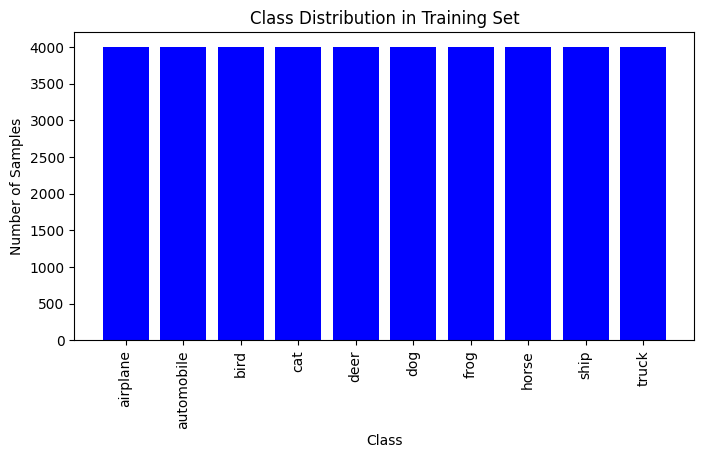

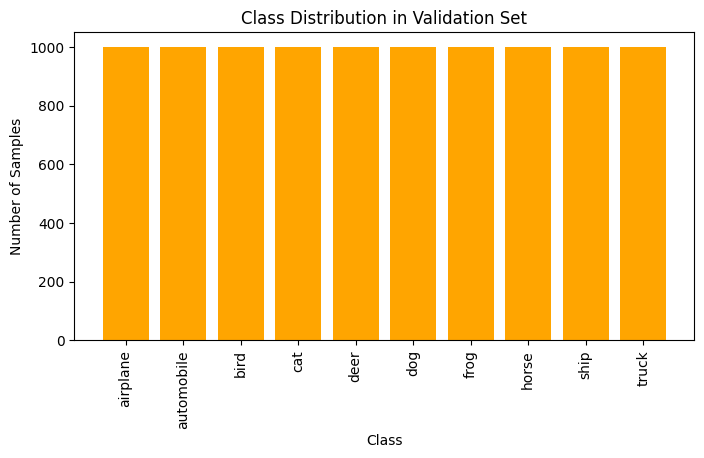

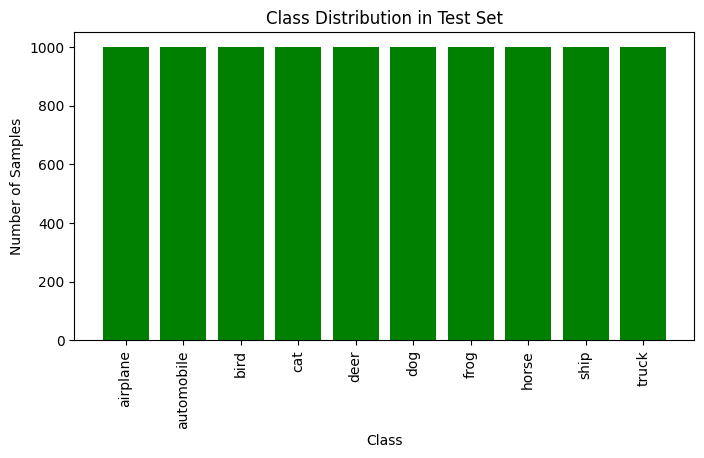

In [4]:
# Print dataset sizes
print(f"Training dataset size: {len(train_subset)} samples")
print(f"Validation dataset size: {len(val_subset)} samples")
print(f"Test dataset size: {len(test_dataset)} samples")

# Plot the distribution for the training set
plt.figure(figsize=(8, 4))
plt.bar(unique_classes, train_class_counts, color='blue')
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.show()

# Plot the distribution for the validation set
plt.figure(figsize=(8, 4))
plt.bar(unique_classes, val_class_counts, color='orange')
plt.title("Class Distribution in Validation Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.show()

# Plot the distribution for the test set
plt.figure(figsize=(8, 4))
plt.bar(unique_classes, test_class_counts, color='green')
plt.title("Class Distribution in Test Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.show()

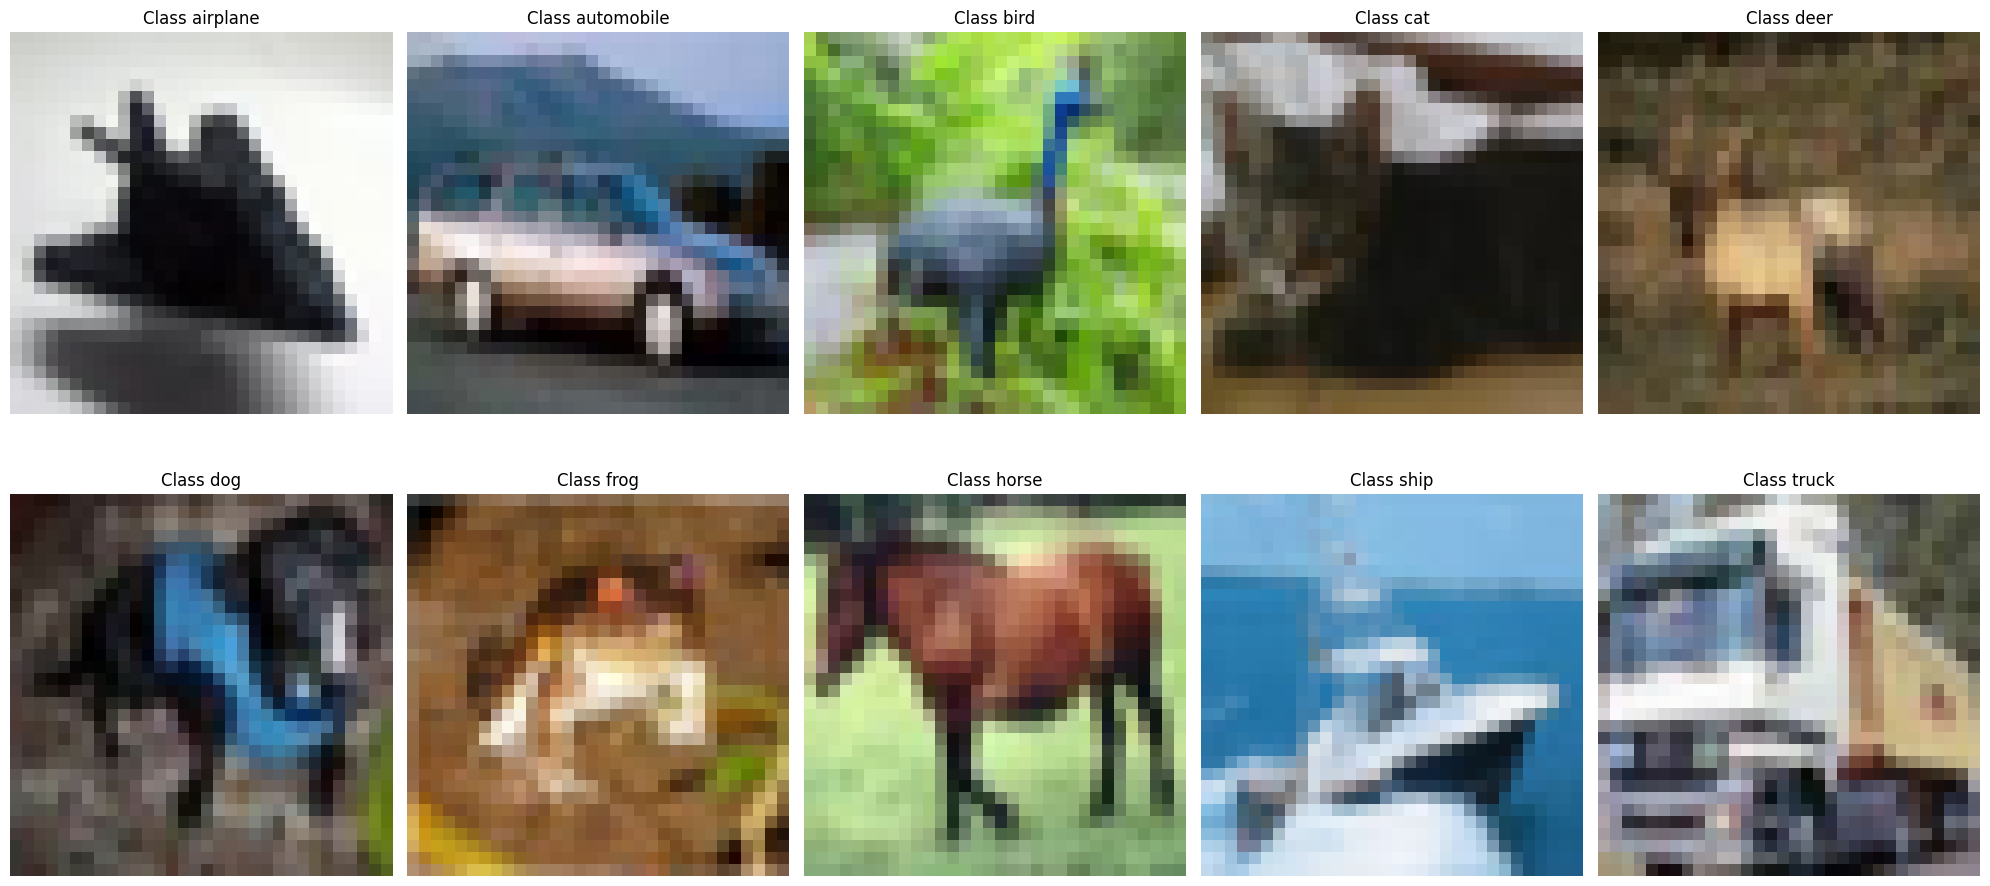

In [5]:
# Visualize sample images for each class
class_samples = {}

# Iterate through the training dataset and select one sample for each class
for img, label in train_dataset:
    class_name = train_dataset.classes[label]
    if class_name not in class_samples:
        class_samples[class_name] = img

    # Break the loop if we already have one sample for each class
    if len(class_samples) == num_classes:
        break

# Plot the sample images for each class
plt.figure(figsize=(20, 10))
for i, cls in enumerate(unique_classes):
    if cls in class_samples:
        img = class_samples[cls]
        img = img / 2 + 0.5  # Unnormalize the image
        np_img = img.numpy()
        np_img = np.transpose(np_img, (1, 2, 0))  # Rearrange dimensions for plotting

        plt.subplot(2, 5, i + 1)  # Create subplots (2 rows, 5 columns)
        plt.imshow(np_img)
        plt.title(f"Class {cls}")
        plt.axis('off')

plt.tight_layout()
plt.show()



### SqueezeNet 1.1 Model Architecture

In [55]:
class Fire(nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand1x1_channels, expand3x3_channels):
        super(Fire, self).__init__()
        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        
        self.expand1x1 = nn.Conv2d(squeeze_channels, expand1x1_channels, kernel_size=1)
        self.expand3x3 = nn.Conv2d(squeeze_channels, expand3x3_channels, kernel_size=3, padding=1)
        
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)

class SqueezeNet_1_1(nn.Module):
    def __init__(self, num_classes=10):
        super(SqueezeNet_1_1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            
            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            
            Fire(128, 32, 128, 128),
            Fire(256, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            
            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            Fire(512, 64, 256, 256),
        )
        
        self.final_conv = nn.Conv2d(512, num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            self.final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


### Defining some trainings function

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Define training model function
def train_model(model, train_dataset, val_dataset, optimizer=optim.Adam, lr=0.001, epoch_num=100, patience=10, model_name="model_name", 
                regularization_type=None, regularization_strength=None):

    optimizer = optimizer(model.parameters(), lr=lr)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float("inf")
    patience_counter = 0
    epochs = epoch_num
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for inputs, labels in tqdm(train_dataset, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Apply regularization if specified
            if regularization_type == "l1":
                l1_reg = sum(param.abs().sum() for param in model.parameters())
                loss += regularization_strength * l1_reg
            elif regularization_type == "l2":
                l2_reg = sum(param.pow(2).sum() for param in model.parameters())
                loss += regularization_strength * l2_reg
            elif regularization_type == "l1_l2":
                l1_reg = sum(param.abs().sum() for param in model.parameters())
                l2_reg = sum(param.pow(2).sum() for param in model.parameters())
                loss += regularization_strength * (l1_reg + l2_reg)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate training accuracy
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= len(train_dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Apply regularization if specified
                if regularization_type == "l1":
                    l1_reg = sum(param.abs().sum() for param in model.parameters())
                    loss += regularization_strength * l1_reg
                elif regularization_type == "l2":
                    l2_reg = sum(param.pow(2).sum() for param in model.parameters())
                    loss += regularization_strength * l2_reg
                elif regularization_type == "l1_l2":
                    l1_reg = sum(param.abs().sum() for param in model.parameters())
                    l2_reg = sum(param.pow(2).sum() for param in model.parameters())
                    loss += regularization_strength * (l1_reg + l2_reg)

                val_loss += loss.item()

                # Calculate validation accuracy
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_dataset)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print results per epoch
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping...")
                break

    # Save the final model at the end of training
    save_path = f"models/{model_name}.pth"  # Define the save path with the custom name
    torch.save(model.state_dict(), save_path)
    print(f"Training complete. Final model saved at '{save_path}'")

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [9]:
def plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name="model_name"):
    plt.figure(figsize=(14, 5))

    # Plot Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"{model_name} - Loss Curves ")
    plt.legend()

    # Plot Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f"{model_name} - Accuracy Curves")
    plt.legend()

    # Display the plots
    plt.show()



In [10]:
# Confusion Matrix Evaluation Function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Plot Confusion Matrix with Adjustable Size
def plot_confusion_matrix(y_true, y_pred, classes, figsize=(10, 10), model_name="model_name"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    # Adjust figure size
    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.xticks(rotation=45)
    plt.title(f"{model_name} - Confusion Matrix ")
    plt.show()



### SqueezeNet 1.1 Base Model

In [14]:
# Hyperparameter tuning
model = SqueezeNet_1_1(num_classes=10)
train_dataset = train_loader
val_dataset = val_loader
optimizer=optim.Adam
learning_rate=0.001
epochs =100
patience=10
regularization=None
regularization_strength=None
models = {}
model_name = "SqueezeNet_1_1_base"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)
#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

Epoch 1/100, Train Loss: 1.9687, Train Accuracy: 0.2450, Validation Loss: 1.7075, Validation Accuracy: 0.3482


Epoch 2/100, Train Loss: 1.6539, Train Accuracy: 0.3732, Validation Loss: 1.5770, Validation Accuracy: 0.4117


Epoch 3/100, Train Loss: 1.5072, Train Accuracy: 0.4373, Validation Loss: 1.4737, Validation Accuracy: 0.4526


Epoch 4/100, Train Loss: 1.4204, Train Accuracy: 0.4776, Validation Loss: 1.3973, Validation Accuracy: 0.4848


Epoch 5/100, Train Loss: 1.3513, Train Accuracy: 0.5080, Validation Loss: 1.3309, Validation Accuracy: 0.5111


Epoch 6/100, Train Loss: 1.2868, Train Accuracy: 0.5378, Validation Loss: 1.2969, Validation Accuracy: 0.5360


Epoch 7/100, Train Loss: 1.2347, Train Accuracy: 0.5585, Validation Loss: 1.2934, Validation Accuracy: 0.5352


Epoch 8/100, Train Loss: 1.1839, Train Accuracy: 0.5758, Validation Loss: 1.2341, Validation Accuracy: 0.5650


Epoch 9/100, Train Loss: 1.1443, Train Accuracy: 0.5943, Validation Loss: 1.2589, Validation Accuracy: 0.5483


Epoch 10/100, Train Loss: 1.1057, Train Accuracy: 0.6056, Validation Loss: 1.2197, Validation Accuracy: 0.5595


Epoch 11/100, Train Loss: 1.0696, Train Accuracy: 0.6211, Validation Loss: 1.2222, Validation Accuracy: 0.5632


Epoch 12/100, Train Loss: 1.0319, Train Accuracy: 0.6331, Validation Loss: 1.2382, Validation Accuracy: 0.5736


Epoch 13/100, Train Loss: 1.0049, Train Accuracy: 0.6471, Validation Loss: 1.2112, Validation Accuracy: 0.5765


Epoch 14/100, Train Loss: 0.9860, Train Accuracy: 0.6511, Validation Loss: 1.2523, Validation Accuracy: 0.5721


Epoch 15/100, Train Loss: 0.9508, Train Accuracy: 0.6640, Validation Loss: 1.1658, Validation Accuracy: 0.5889


Epoch 16/100, Train Loss: 0.9038, Train Accuracy: 0.6813, Validation Loss: 1.1667, Validation Accuracy: 0.6007


Epoch 17/100, Train Loss: 0.8922, Train Accuracy: 0.6865, Validation Loss: 1.1809, Validation Accuracy: 0.5976


Epoch 18/100, Train Loss: 0.8515, Train Accuracy: 0.6982, Validation Loss: 1.1984, Validation Accuracy: 0.6032


Epoch 19/100, Train Loss: 0.8262, Train Accuracy: 0.7104, Validation Loss: 1.2852, Validation Accuracy: 0.5807


Epoch 20/100, Train Loss: 0.8017, Train Accuracy: 0.7182, Validation Loss: 1.2210, Validation Accuracy: 0.5970


Epoch 21/100, Train Loss: 0.7852, Train Accuracy: 0.7219, Validation Loss: 1.2109, Validation Accuracy: 0.6112


Epoch 22/100, Train Loss: 0.7589, Train Accuracy: 0.7315, Validation Loss: 1.3124, Validation Accuracy: 0.5925


Epoch 23/100, Train Loss: 0.7461, Train Accuracy: 0.7392, Validation Loss: 1.2948, Validation Accuracy: 0.5930


Epoch 24/100, Train Loss: 0.7094, Train Accuracy: 0.7500, Validation Loss: 1.3525, Validation Accuracy: 0.5768


Epoch 25/100, Train Loss: 0.6901, Train Accuracy: 0.7582, Validation Loss: 1.3248, Validation Accuracy: 0.6043
Early stopping...
Training complete. Final model saved at 'models/SqueezeNet_1_1_base.pth'


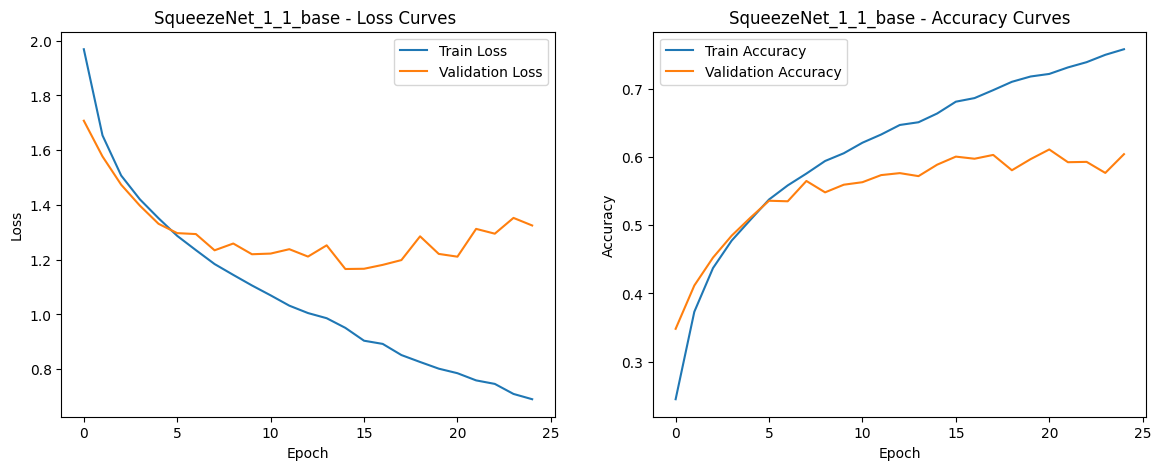

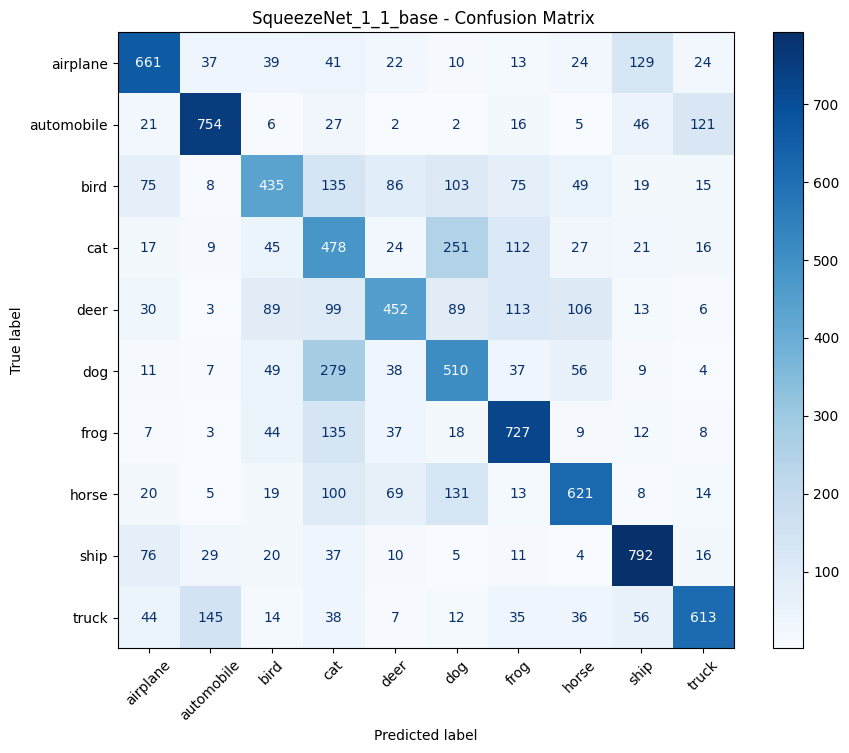

In [15]:
# Loss and accuracy curves 
model_name = "SqueezeNet_1_1_base"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 

## OPTIMISATION

### SqueezeNet 1.1 model optimisation-1

In [16]:
# Hyperparameter tuning
model = SqueezeNet_1_1(num_classes=10)
train_dataset = train_loader
val_dataset = val_loader
optimizer=optim.Adam
learning_rate=0.0001
epochs =100
patience=10
regularization="L1"
regularization_strength=0.001
models = {}
model_name = "SqueezeNet_1_1_opt1"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

Epoch 1/100, Train Loss: 2.2326, Train Accuracy: 0.1776, Validation Loss: 2.0824, Validation Accuracy: 0.2689


Epoch 2/100, Train Loss: 1.9854, Train Accuracy: 0.2776, Validation Loss: 1.8146, Validation Accuracy: 0.3438


Epoch 3/100, Train Loss: 1.8042, Train Accuracy: 0.3424, Validation Loss: 1.6860, Validation Accuracy: 0.3979


Epoch 4/100, Train Loss: 1.7044, Train Accuracy: 0.3799, Validation Loss: 1.6308, Validation Accuracy: 0.4089


Epoch 5/100, Train Loss: 1.6390, Train Accuracy: 0.4083, Validation Loss: 1.5811, Validation Accuracy: 0.4329


Epoch 6/100, Train Loss: 1.5796, Train Accuracy: 0.4321, Validation Loss: 1.5564, Validation Accuracy: 0.4410


Epoch 7/100, Train Loss: 1.5378, Train Accuracy: 0.4471, Validation Loss: 1.5199, Validation Accuracy: 0.4578


Epoch 8/100, Train Loss: 1.4938, Train Accuracy: 0.4642, Validation Loss: 1.4972, Validation Accuracy: 0.4639


Epoch 9/100, Train Loss: 1.4673, Train Accuracy: 0.4751, Validation Loss: 1.4793, Validation Accuracy: 0.4709


Epoch 10/100, Train Loss: 1.4332, Train Accuracy: 0.4877, Validation Loss: 1.4483, Validation Accuracy: 0.4844


Epoch 11/100, Train Loss: 1.4094, Train Accuracy: 0.4959, Validation Loss: 1.4416, Validation Accuracy: 0.4896


Epoch 12/100, Train Loss: 1.3844, Train Accuracy: 0.5067, Validation Loss: 1.4385, Validation Accuracy: 0.4872


Epoch 13/100, Train Loss: 1.3641, Train Accuracy: 0.5124, Validation Loss: 1.4255, Validation Accuracy: 0.4952


Epoch 14/100, Train Loss: 1.3474, Train Accuracy: 0.5211, Validation Loss: 1.4174, Validation Accuracy: 0.4999


Epoch 15/100, Train Loss: 1.3248, Train Accuracy: 0.5248, Validation Loss: 1.4091, Validation Accuracy: 0.5012


Epoch 16/100, Train Loss: 1.3041, Train Accuracy: 0.5363, Validation Loss: 1.3999, Validation Accuracy: 0.5053


Epoch 17/100, Train Loss: 1.2864, Train Accuracy: 0.5436, Validation Loss: 1.3834, Validation Accuracy: 0.5150


Epoch 18/100, Train Loss: 1.2724, Train Accuracy: 0.5450, Validation Loss: 1.3807, Validation Accuracy: 0.5180


Epoch 19/100, Train Loss: 1.2603, Train Accuracy: 0.5530, Validation Loss: 1.3938, Validation Accuracy: 0.5057


Epoch 20/100, Train Loss: 1.2463, Train Accuracy: 0.5588, Validation Loss: 1.3602, Validation Accuracy: 0.5227


Epoch 21/100, Train Loss: 1.2255, Train Accuracy: 0.5655, Validation Loss: 1.3843, Validation Accuracy: 0.5137


Epoch 22/100, Train Loss: 1.2141, Train Accuracy: 0.5720, Validation Loss: 1.3521, Validation Accuracy: 0.5239


Epoch 23/100, Train Loss: 1.2073, Train Accuracy: 0.5720, Validation Loss: 1.3536, Validation Accuracy: 0.5304


Epoch 24/100, Train Loss: 1.1840, Train Accuracy: 0.5840, Validation Loss: 1.3702, Validation Accuracy: 0.5258


Epoch 25/100, Train Loss: 1.1701, Train Accuracy: 0.5867, Validation Loss: 1.3786, Validation Accuracy: 0.5277


Epoch 26/100, Train Loss: 1.1634, Train Accuracy: 0.5891, Validation Loss: 1.3508, Validation Accuracy: 0.5298


Epoch 27/100, Train Loss: 1.1427, Train Accuracy: 0.5968, Validation Loss: 1.3505, Validation Accuracy: 0.5310


Epoch 28/100, Train Loss: 1.1331, Train Accuracy: 0.6024, Validation Loss: 1.3523, Validation Accuracy: 0.5328


Epoch 29/100, Train Loss: 1.1232, Train Accuracy: 0.6078, Validation Loss: 1.3401, Validation Accuracy: 0.5352


Epoch 30/100, Train Loss: 1.1054, Train Accuracy: 0.6113, Validation Loss: 1.3536, Validation Accuracy: 0.5321


Epoch 31/100, Train Loss: 1.1032, Train Accuracy: 0.6117, Validation Loss: 1.3530, Validation Accuracy: 0.5346


Epoch 32/100, Train Loss: 1.0832, Train Accuracy: 0.6201, Validation Loss: 1.3454, Validation Accuracy: 0.5336


Epoch 33/100, Train Loss: 1.0747, Train Accuracy: 0.6252, Validation Loss: 1.3652, Validation Accuracy: 0.5346


Epoch 34/100, Train Loss: 1.0605, Train Accuracy: 0.6294, Validation Loss: 1.3532, Validation Accuracy: 0.5413


Epoch 35/100, Train Loss: 1.0565, Train Accuracy: 0.6302, Validation Loss: 1.3692, Validation Accuracy: 0.5292


Epoch 36/100, Train Loss: 1.0460, Train Accuracy: 0.6335, Validation Loss: 1.3709, Validation Accuracy: 0.5362


Epoch 37/100, Train Loss: 1.0327, Train Accuracy: 0.6401, Validation Loss: 1.3644, Validation Accuracy: 0.5330


Epoch 38/100, Train Loss: 1.0188, Train Accuracy: 0.6448, Validation Loss: 1.3781, Validation Accuracy: 0.5393


Epoch 39/100, Train Loss: 1.0055, Train Accuracy: 0.6477, Validation Loss: 1.3665, Validation Accuracy: 0.5396
Early stopping...
Training complete. Final model saved at 'models/SqueezeNet_1_1_opt1.pth'


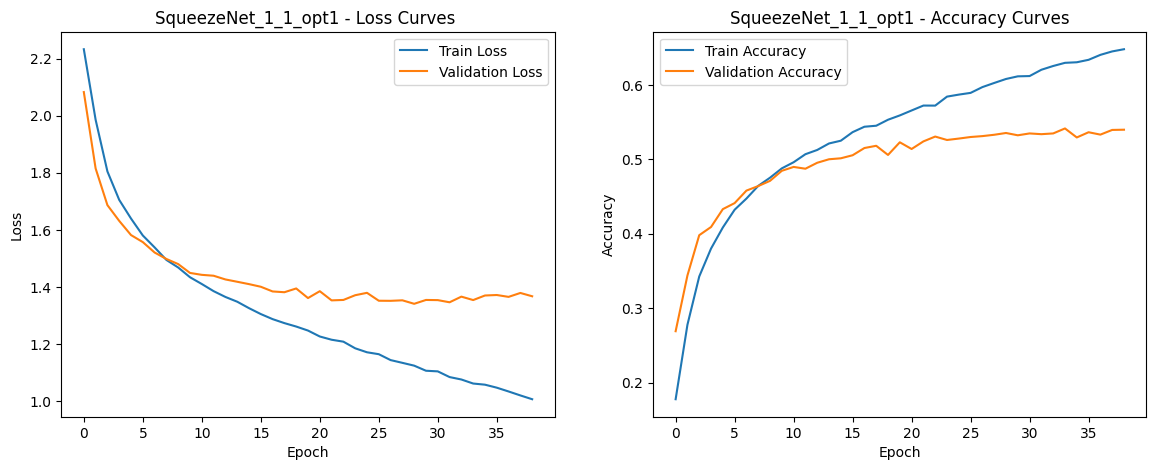

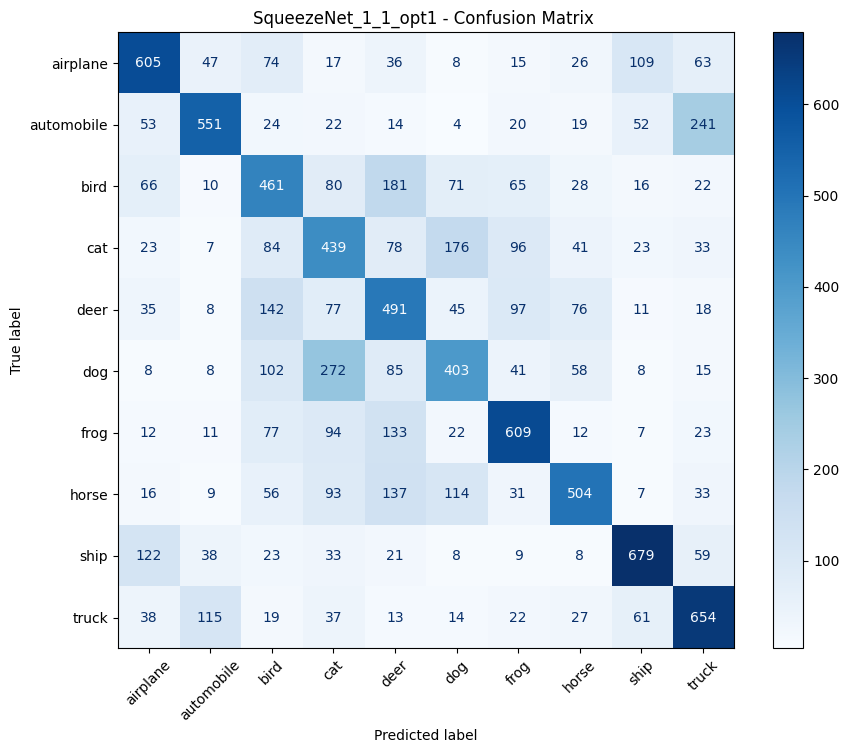

In [17]:
# Loss and accuracy curves 
model_name = "SqueezeNet_1_1_opt1"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 


### SqueezeNet 1.1 model optimisation-2

In [18]:
# Hyperparameter tuning
model = SqueezeNet_1_1(num_classes=10)
train_dataset = train_loader
val_dataset = val_loader
optimizer=optim.Adam
learning_rate=0.0001
epochs =100
patience=10
regularization="L2"
regularization_strength=0.0001
models = {}
model_name = "SqueezeNet_1_1_opt2"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

Epoch 1/100, Train Loss: 2.1972, Train Accuracy: 0.1688, Validation Loss: 2.0256, Validation Accuracy: 0.2530


Epoch 2/100, Train Loss: 1.9305, Train Accuracy: 0.2694, Validation Loss: 1.7984, Validation Accuracy: 0.3208


Epoch 3/100, Train Loss: 1.7769, Train Accuracy: 0.3278, Validation Loss: 1.6791, Validation Accuracy: 0.3683


Epoch 4/100, Train Loss: 1.6910, Train Accuracy: 0.3659, Validation Loss: 1.6133, Validation Accuracy: 0.3925


Epoch 5/100, Train Loss: 1.6303, Train Accuracy: 0.3938, Validation Loss: 1.5658, Validation Accuracy: 0.4155


Epoch 6/100, Train Loss: 1.5800, Train Accuracy: 0.4152, Validation Loss: 1.5362, Validation Accuracy: 0.4264


Epoch 7/100, Train Loss: 1.5461, Train Accuracy: 0.4318, Validation Loss: 1.5105, Validation Accuracy: 0.4391


Epoch 8/100, Train Loss: 1.5162, Train Accuracy: 0.4420, Validation Loss: 1.5091, Validation Accuracy: 0.4377


Epoch 9/100, Train Loss: 1.4835, Train Accuracy: 0.4591, Validation Loss: 1.4993, Validation Accuracy: 0.4465


Epoch 10/100, Train Loss: 1.4597, Train Accuracy: 0.4676, Validation Loss: 1.4654, Validation Accuracy: 0.4592


Epoch 11/100, Train Loss: 1.4393, Train Accuracy: 0.4752, Validation Loss: 1.4526, Validation Accuracy: 0.4703


Epoch 12/100, Train Loss: 1.4111, Train Accuracy: 0.4911, Validation Loss: 1.4242, Validation Accuracy: 0.4766


Epoch 13/100, Train Loss: 1.3935, Train Accuracy: 0.4940, Validation Loss: 1.4175, Validation Accuracy: 0.4819


Epoch 14/100, Train Loss: 1.3756, Train Accuracy: 0.5038, Validation Loss: 1.4058, Validation Accuracy: 0.4873


Epoch 15/100, Train Loss: 1.3562, Train Accuracy: 0.5116, Validation Loss: 1.4073, Validation Accuracy: 0.4830


Epoch 16/100, Train Loss: 1.3392, Train Accuracy: 0.5167, Validation Loss: 1.3838, Validation Accuracy: 0.4956


Epoch 17/100, Train Loss: 1.3198, Train Accuracy: 0.5254, Validation Loss: 1.3922, Validation Accuracy: 0.4889


Epoch 18/100, Train Loss: 1.3113, Train Accuracy: 0.5281, Validation Loss: 1.3740, Validation Accuracy: 0.5046


Epoch 19/100, Train Loss: 1.2935, Train Accuracy: 0.5357, Validation Loss: 1.3905, Validation Accuracy: 0.4992


Epoch 20/100, Train Loss: 1.2822, Train Accuracy: 0.5401, Validation Loss: 1.3480, Validation Accuracy: 0.5123


Epoch 21/100, Train Loss: 1.2592, Train Accuracy: 0.5496, Validation Loss: 1.3544, Validation Accuracy: 0.5056


Epoch 22/100, Train Loss: 1.2478, Train Accuracy: 0.5509, Validation Loss: 1.3432, Validation Accuracy: 0.5087


Epoch 23/100, Train Loss: 1.2323, Train Accuracy: 0.5575, Validation Loss: 1.3581, Validation Accuracy: 0.5149


Epoch 24/100, Train Loss: 1.2254, Train Accuracy: 0.5624, Validation Loss: 1.3318, Validation Accuracy: 0.5200


Epoch 25/100, Train Loss: 1.2087, Train Accuracy: 0.5689, Validation Loss: 1.3539, Validation Accuracy: 0.5202


Epoch 26/100, Train Loss: 1.1937, Train Accuracy: 0.5723, Validation Loss: 1.3177, Validation Accuracy: 0.5238


Epoch 27/100, Train Loss: 1.1866, Train Accuracy: 0.5772, Validation Loss: 1.3229, Validation Accuracy: 0.5305


Epoch 28/100, Train Loss: 1.1674, Train Accuracy: 0.5819, Validation Loss: 1.3126, Validation Accuracy: 0.5293


Epoch 29/100, Train Loss: 1.1571, Train Accuracy: 0.5861, Validation Loss: 1.3138, Validation Accuracy: 0.5290


Epoch 30/100, Train Loss: 1.1492, Train Accuracy: 0.5929, Validation Loss: 1.3338, Validation Accuracy: 0.5247


Epoch 31/100, Train Loss: 1.1352, Train Accuracy: 0.5966, Validation Loss: 1.3132, Validation Accuracy: 0.5337


Epoch 32/100, Train Loss: 1.1195, Train Accuracy: 0.6023, Validation Loss: 1.3200, Validation Accuracy: 0.5287


Epoch 33/100, Train Loss: 1.1143, Train Accuracy: 0.6042, Validation Loss: 1.3104, Validation Accuracy: 0.5360


Epoch 34/100, Train Loss: 1.1022, Train Accuracy: 0.6078, Validation Loss: 1.3093, Validation Accuracy: 0.5351


Epoch 35/100, Train Loss: 1.0932, Train Accuracy: 0.6140, Validation Loss: 1.3458, Validation Accuracy: 0.5219


Epoch 36/100, Train Loss: 1.0764, Train Accuracy: 0.6192, Validation Loss: 1.3195, Validation Accuracy: 0.5413


Epoch 37/100, Train Loss: 1.0710, Train Accuracy: 0.6218, Validation Loss: 1.3235, Validation Accuracy: 0.5374


Epoch 38/100, Train Loss: 1.0638, Train Accuracy: 0.6246, Validation Loss: 1.3306, Validation Accuracy: 0.5400


Epoch 39/100, Train Loss: 1.0553, Train Accuracy: 0.6269, Validation Loss: 1.3347, Validation Accuracy: 0.5450


Epoch 40/100, Train Loss: 1.0445, Train Accuracy: 0.6320, Validation Loss: 1.3309, Validation Accuracy: 0.5418


Epoch 41/100, Train Loss: 1.0382, Train Accuracy: 0.6343, Validation Loss: 1.3162, Validation Accuracy: 0.5439


Epoch 42/100, Train Loss: 1.0188, Train Accuracy: 0.6420, Validation Loss: 1.3200, Validation Accuracy: 0.5452


Epoch 43/100, Train Loss: 1.0147, Train Accuracy: 0.6425, Validation Loss: 1.3344, Validation Accuracy: 0.5385


Epoch 44/100, Train Loss: 1.0054, Train Accuracy: 0.6465, Validation Loss: 1.3527, Validation Accuracy: 0.5372
Early stopping...
Training complete. Final model saved at 'models/SqueezeNet_1_1_opt2.pth'


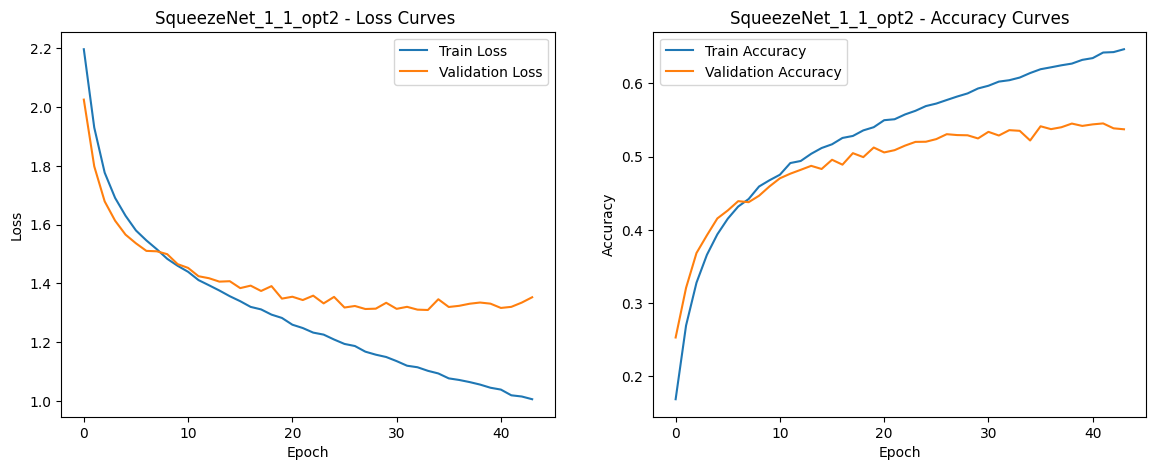

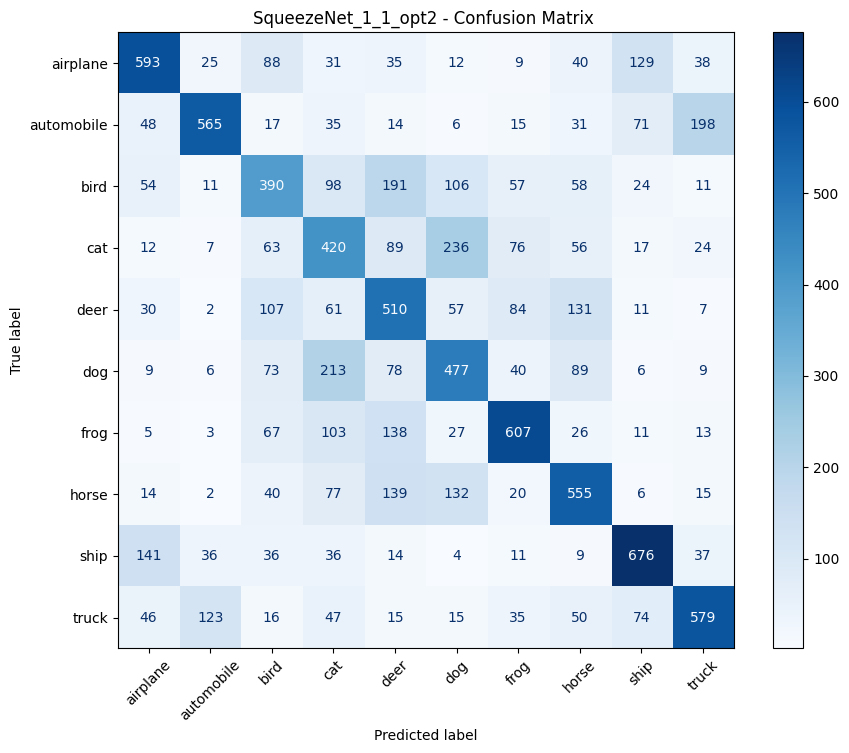

In [19]:
# Loss and accuracy curves 
model_name = "SqueezeNet_1_1_opt2"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 

### SqueezeNet 1.1 model optimisation-3

In [20]:
# Hyperparameter tuning
model = SqueezeNet_1_1(num_classes=10)
train_dataset = train_loader
val_dataset = val_loader
optimizer=optim.Adam
learning_rate=0.0001
epochs =100
patience=10
regularization="L1L2"
regularization_strength=0.001
models = {}
model_name = "SqueezeNet_1_1_opt3"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc


Epoch 1/100, Train Loss: 2.2004, Train Accuracy: 0.1924, Validation Loss: 2.0256, Validation Accuracy: 0.2864


Epoch 2/100, Train Loss: 1.9290, Train Accuracy: 0.3030, Validation Loss: 1.7684, Validation Accuracy: 0.3635


Epoch 3/100, Train Loss: 1.7654, Train Accuracy: 0.3541, Validation Loss: 1.6725, Validation Accuracy: 0.3882


Epoch 4/100, Train Loss: 1.6880, Train Accuracy: 0.3796, Validation Loss: 1.6271, Validation Accuracy: 0.4088


Epoch 5/100, Train Loss: 1.6270, Train Accuracy: 0.4057, Validation Loss: 1.5675, Validation Accuracy: 0.4272


Epoch 6/100, Train Loss: 1.5785, Train Accuracy: 0.4242, Validation Loss: 1.5301, Validation Accuracy: 0.4449


Epoch 7/100, Train Loss: 1.5347, Train Accuracy: 0.4401, Validation Loss: 1.5194, Validation Accuracy: 0.4494


Epoch 8/100, Train Loss: 1.5011, Train Accuracy: 0.4553, Validation Loss: 1.4920, Validation Accuracy: 0.4537


Epoch 9/100, Train Loss: 1.4731, Train Accuracy: 0.4628, Validation Loss: 1.4629, Validation Accuracy: 0.4706


Epoch 10/100, Train Loss: 1.4429, Train Accuracy: 0.4786, Validation Loss: 1.4668, Validation Accuracy: 0.4674


Epoch 11/100, Train Loss: 1.4168, Train Accuracy: 0.4888, Validation Loss: 1.4291, Validation Accuracy: 0.4813


Epoch 12/100, Train Loss: 1.3894, Train Accuracy: 0.4988, Validation Loss: 1.4157, Validation Accuracy: 0.4858


Epoch 13/100, Train Loss: 1.3675, Train Accuracy: 0.5079, Validation Loss: 1.4044, Validation Accuracy: 0.4886


Epoch 14/100, Train Loss: 1.3495, Train Accuracy: 0.5158, Validation Loss: 1.3863, Validation Accuracy: 0.4986


Epoch 15/100, Train Loss: 1.3359, Train Accuracy: 0.5197, Validation Loss: 1.3844, Validation Accuracy: 0.4962


Epoch 16/100, Train Loss: 1.3126, Train Accuracy: 0.5296, Validation Loss: 1.3703, Validation Accuracy: 0.5071


Epoch 17/100, Train Loss: 1.2907, Train Accuracy: 0.5363, Validation Loss: 1.3649, Validation Accuracy: 0.5070


Epoch 18/100, Train Loss: 1.2784, Train Accuracy: 0.5430, Validation Loss: 1.3594, Validation Accuracy: 0.5134


Epoch 19/100, Train Loss: 1.2562, Train Accuracy: 0.5503, Validation Loss: 1.3476, Validation Accuracy: 0.5189


Epoch 20/100, Train Loss: 1.2454, Train Accuracy: 0.5523, Validation Loss: 1.3585, Validation Accuracy: 0.5102


Epoch 21/100, Train Loss: 1.2285, Train Accuracy: 0.5621, Validation Loss: 1.3548, Validation Accuracy: 0.5162


Epoch 22/100, Train Loss: 1.2202, Train Accuracy: 0.5631, Validation Loss: 1.3485, Validation Accuracy: 0.5176


Epoch 23/100, Train Loss: 1.2059, Train Accuracy: 0.5677, Validation Loss: 1.3283, Validation Accuracy: 0.5255


Epoch 24/100, Train Loss: 1.1880, Train Accuracy: 0.5777, Validation Loss: 1.3211, Validation Accuracy: 0.5263


Epoch 25/100, Train Loss: 1.1732, Train Accuracy: 0.5813, Validation Loss: 1.3278, Validation Accuracy: 0.5306


Epoch 26/100, Train Loss: 1.1581, Train Accuracy: 0.5877, Validation Loss: 1.3771, Validation Accuracy: 0.5172


Epoch 27/100, Train Loss: 1.1510, Train Accuracy: 0.5891, Validation Loss: 1.3052, Validation Accuracy: 0.5320


Epoch 28/100, Train Loss: 1.1376, Train Accuracy: 0.5956, Validation Loss: 1.3167, Validation Accuracy: 0.5314


Epoch 29/100, Train Loss: 1.1215, Train Accuracy: 0.6020, Validation Loss: 1.3035, Validation Accuracy: 0.5412


Epoch 30/100, Train Loss: 1.1041, Train Accuracy: 0.6082, Validation Loss: 1.3366, Validation Accuracy: 0.5345


Epoch 31/100, Train Loss: 1.0953, Train Accuracy: 0.6101, Validation Loss: 1.3510, Validation Accuracy: 0.5225


Epoch 32/100, Train Loss: 1.0898, Train Accuracy: 0.6132, Validation Loss: 1.3200, Validation Accuracy: 0.5424


Epoch 33/100, Train Loss: 1.0768, Train Accuracy: 0.6173, Validation Loss: 1.3313, Validation Accuracy: 0.5395


Epoch 34/100, Train Loss: 1.0695, Train Accuracy: 0.6200, Validation Loss: 1.2992, Validation Accuracy: 0.5458


Epoch 35/100, Train Loss: 1.0533, Train Accuracy: 0.6255, Validation Loss: 1.3086, Validation Accuracy: 0.5430


Epoch 36/100, Train Loss: 1.0455, Train Accuracy: 0.6307, Validation Loss: 1.3193, Validation Accuracy: 0.5412


Epoch 37/100, Train Loss: 1.0367, Train Accuracy: 0.6318, Validation Loss: 1.3363, Validation Accuracy: 0.5411


Epoch 38/100, Train Loss: 1.0283, Train Accuracy: 0.6358, Validation Loss: 1.3059, Validation Accuracy: 0.5462


Epoch 39/100, Train Loss: 1.0151, Train Accuracy: 0.6403, Validation Loss: 1.3148, Validation Accuracy: 0.5474


Epoch 40/100, Train Loss: 1.0045, Train Accuracy: 0.6430, Validation Loss: 1.3230, Validation Accuracy: 0.5474


Epoch 41/100, Train Loss: 0.9954, Train Accuracy: 0.6468, Validation Loss: 1.3115, Validation Accuracy: 0.5484


Epoch 42/100, Train Loss: 0.9838, Train Accuracy: 0.6523, Validation Loss: 1.3239, Validation Accuracy: 0.5468


Epoch 43/100, Train Loss: 0.9757, Train Accuracy: 0.6559, Validation Loss: 1.3372, Validation Accuracy: 0.5442


Epoch 44/100, Train Loss: 0.9600, Train Accuracy: 0.6604, Validation Loss: 1.3297, Validation Accuracy: 0.5478
Early stopping...
Training complete. Final model saved at 'models/SqueezeNet_1_1_opt3.pth'


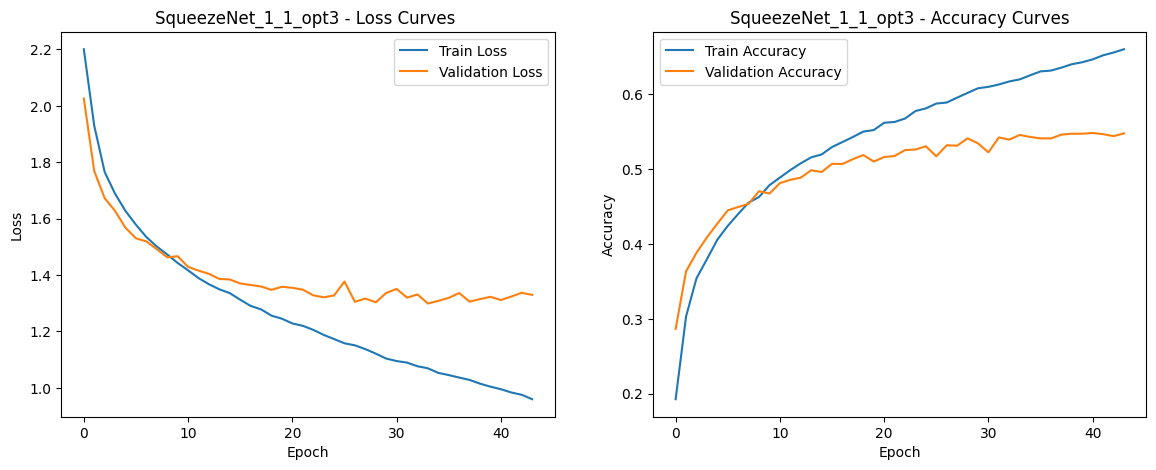

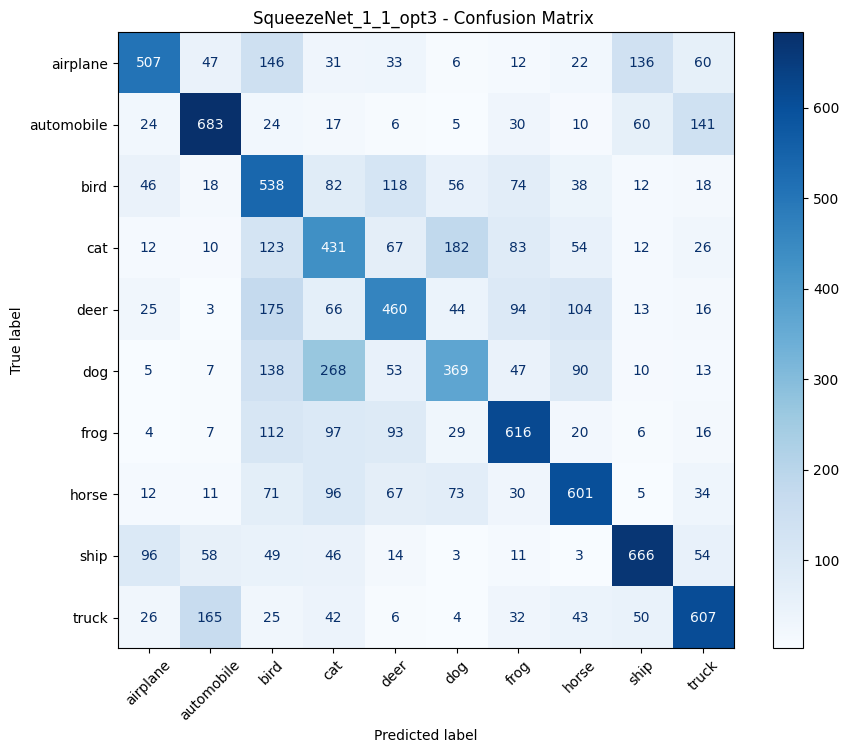

In [21]:
# Loss and accuracy curves 
model_name = "SqueezeNet_1_1_opt3"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 

### SqueezeNet 1.1 model optimisation-4

In [23]:
# Update batch size
train_loader_128 = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=4)
val_loader_128 = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4)

# Hyperparameter tuning
model = SqueezeNet_1_1(num_classes=10)
train_dataset = train_loader_128
val_dataset = val_loader_128
optimizer=optim.Adam
learning_rate=0.0001
epochs =100
patience=10
regularization="L2"
regularization_strength=0.01
models = {}
model_name = "SqueezeNet_1_1_opt4"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc



Epoch 1/100, Train Loss: 2.1334, Train Accuracy: 0.2128, Validation Loss: 1.8527, Validation Accuracy: 0.3164


Epoch 2/100, Train Loss: 1.7987, Train Accuracy: 0.3395, Validation Loss: 1.6655, Validation Accuracy: 0.3947


Epoch 3/100, Train Loss: 1.6691, Train Accuracy: 0.3910, Validation Loss: 1.5897, Validation Accuracy: 0.4214


Epoch 4/100, Train Loss: 1.5949, Train Accuracy: 0.4188, Validation Loss: 1.5397, Validation Accuracy: 0.4419


Epoch 5/100, Train Loss: 1.5276, Train Accuracy: 0.4459, Validation Loss: 1.4971, Validation Accuracy: 0.4539


Epoch 6/100, Train Loss: 1.4830, Train Accuracy: 0.4654, Validation Loss: 1.4572, Validation Accuracy: 0.4656


Epoch 7/100, Train Loss: 1.4364, Train Accuracy: 0.4812, Validation Loss: 1.4442, Validation Accuracy: 0.4778


Epoch 8/100, Train Loss: 1.4084, Train Accuracy: 0.4949, Validation Loss: 1.4144, Validation Accuracy: 0.4905


Epoch 9/100, Train Loss: 1.3743, Train Accuracy: 0.5064, Validation Loss: 1.3893, Validation Accuracy: 0.4976


Epoch 10/100, Train Loss: 1.3479, Train Accuracy: 0.5156, Validation Loss: 1.3899, Validation Accuracy: 0.5008


Epoch 11/100, Train Loss: 1.3251, Train Accuracy: 0.5264, Validation Loss: 1.3857, Validation Accuracy: 0.5006


Epoch 12/100, Train Loss: 1.3037, Train Accuracy: 0.5326, Validation Loss: 1.3630, Validation Accuracy: 0.5105


Epoch 13/100, Train Loss: 1.2752, Train Accuracy: 0.5471, Validation Loss: 1.3359, Validation Accuracy: 0.5191


Epoch 14/100, Train Loss: 1.2564, Train Accuracy: 0.5511, Validation Loss: 1.3173, Validation Accuracy: 0.5269


Epoch 15/100, Train Loss: 1.2329, Train Accuracy: 0.5598, Validation Loss: 1.3357, Validation Accuracy: 0.5236


Epoch 16/100, Train Loss: 1.2197, Train Accuracy: 0.5671, Validation Loss: 1.3063, Validation Accuracy: 0.5351


Epoch 17/100, Train Loss: 1.2040, Train Accuracy: 0.5710, Validation Loss: 1.3633, Validation Accuracy: 0.5223


Epoch 18/100, Train Loss: 1.1801, Train Accuracy: 0.5818, Validation Loss: 1.2968, Validation Accuracy: 0.5389


Epoch 19/100, Train Loss: 1.1619, Train Accuracy: 0.5859, Validation Loss: 1.3211, Validation Accuracy: 0.5344


Epoch 20/100, Train Loss: 1.1457, Train Accuracy: 0.5941, Validation Loss: 1.3283, Validation Accuracy: 0.5329


Epoch 21/100, Train Loss: 1.1293, Train Accuracy: 0.5999, Validation Loss: 1.2910, Validation Accuracy: 0.5482


Epoch 22/100, Train Loss: 1.1140, Train Accuracy: 0.6063, Validation Loss: 1.2872, Validation Accuracy: 0.5496


Epoch 23/100, Train Loss: 1.1013, Train Accuracy: 0.6097, Validation Loss: 1.3222, Validation Accuracy: 0.5373


Epoch 24/100, Train Loss: 1.0887, Train Accuracy: 0.6162, Validation Loss: 1.2878, Validation Accuracy: 0.5523


Epoch 25/100, Train Loss: 1.0665, Train Accuracy: 0.6220, Validation Loss: 1.2889, Validation Accuracy: 0.5556


Epoch 26/100, Train Loss: 1.0567, Train Accuracy: 0.6267, Validation Loss: 1.2807, Validation Accuracy: 0.5532


Epoch 27/100, Train Loss: 1.0474, Train Accuracy: 0.6297, Validation Loss: 1.2894, Validation Accuracy: 0.5502


Epoch 28/100, Train Loss: 1.0315, Train Accuracy: 0.6352, Validation Loss: 1.2788, Validation Accuracy: 0.5548


Epoch 29/100, Train Loss: 1.0119, Train Accuracy: 0.6419, Validation Loss: 1.2798, Validation Accuracy: 0.5587


Epoch 30/100, Train Loss: 0.9996, Train Accuracy: 0.6482, Validation Loss: 1.2938, Validation Accuracy: 0.5566


Epoch 31/100, Train Loss: 0.9906, Train Accuracy: 0.6508, Validation Loss: 1.3359, Validation Accuracy: 0.5587


Epoch 32/100, Train Loss: 0.9761, Train Accuracy: 0.6557, Validation Loss: 1.3277, Validation Accuracy: 0.5529


Epoch 33/100, Train Loss: 0.9637, Train Accuracy: 0.6618, Validation Loss: 1.3169, Validation Accuracy: 0.5487


Epoch 34/100, Train Loss: 0.9554, Train Accuracy: 0.6643, Validation Loss: 1.3050, Validation Accuracy: 0.5577


Epoch 35/100, Train Loss: 0.9353, Train Accuracy: 0.6731, Validation Loss: 1.3182, Validation Accuracy: 0.5535


Epoch 36/100, Train Loss: 0.9279, Train Accuracy: 0.6732, Validation Loss: 1.3146, Validation Accuracy: 0.5612


Epoch 37/100, Train Loss: 0.9127, Train Accuracy: 0.6822, Validation Loss: 1.3916, Validation Accuracy: 0.5540


Epoch 38/100, Train Loss: 0.9039, Train Accuracy: 0.6834, Validation Loss: 1.3548, Validation Accuracy: 0.5516
Early stopping...
Training complete. Final model saved at 'models/SqueezeNet_1_1_opt4.pth'


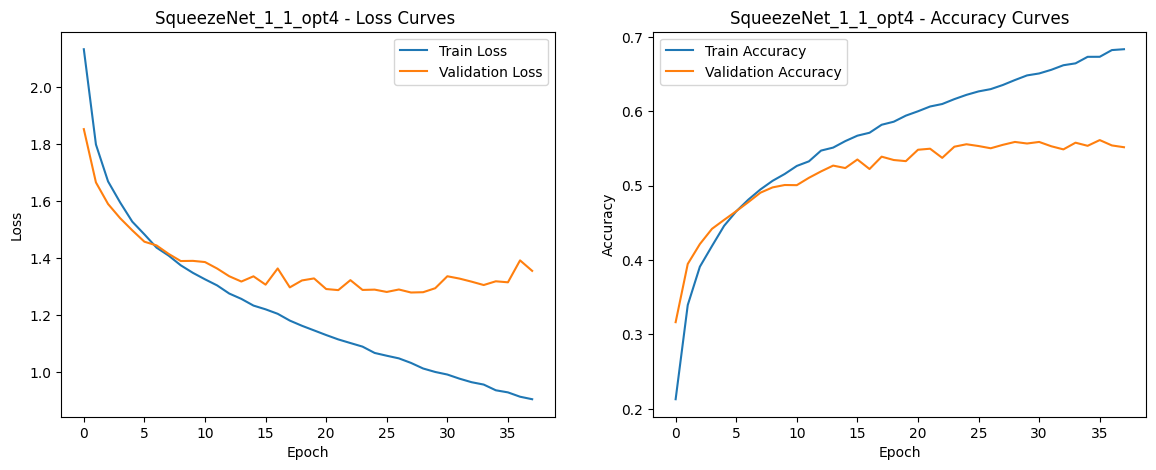

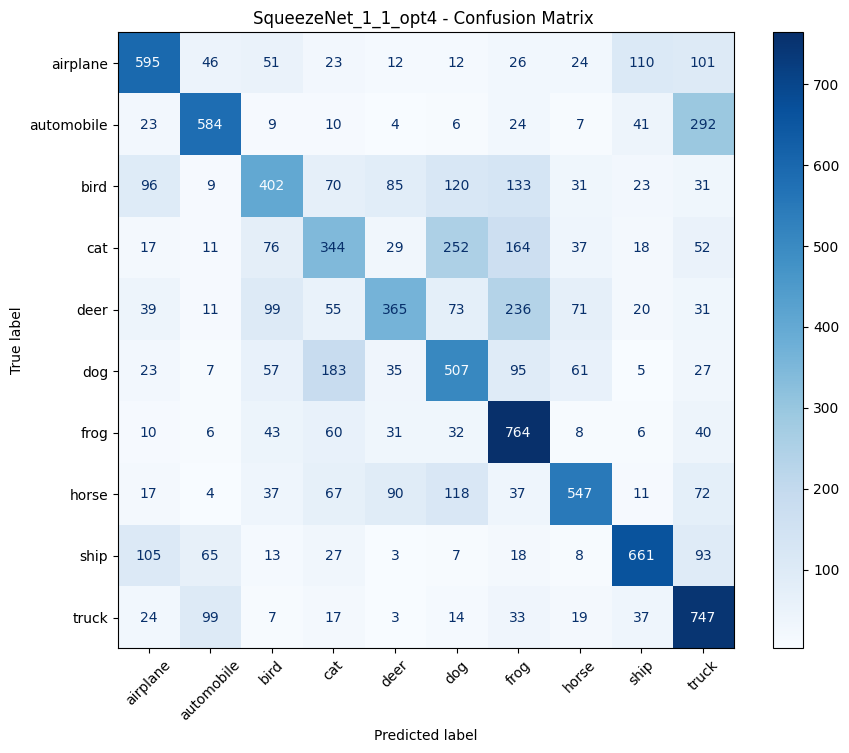

In [24]:
# Loss and accuracy curves 
model_name = "SqueezeNet_1_1_opt4"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 

### SqueezeNet 1.1 model optimisation-5

In [30]:
# Define the augmentations method
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 datasets with transformations
train_dataset_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)

# Split the training dataset into 80% training and 20% validation
train_indices_aug, val_indices_aug = train_test_split(
    range(len(train_dataset_aug)),
    test_size=0.2,
    stratify=[label for _, label in train_dataset_aug],
    random_state=42
)

train_subset_aug = Subset(train_dataset_aug, train_indices_aug)

# DataLoaders, edit batch size
train_loader_aug = DataLoader(train_subset_aug, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader_128 = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

In [33]:
# Hyperparameter tuning
model = SqueezeNet_1_1(num_classes=10)
train_dataset = train_loader_128
val_dataset = val_loader_128
optimizer=optim.Adam
learning_rate=0.001
epochs =100
patience=10
regularization=None
regularization_strength=None
models = {}
model_name = "SqueezeNet_1_1_opt5"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

Epoch 1/100, Train Loss: 2.0894, Train Accuracy: 0.2228, Validation Loss: 1.8871, Validation Accuracy: 0.2948


Epoch 2/100, Train Loss: 1.8046, Train Accuracy: 0.3351, Validation Loss: 1.7249, Validation Accuracy: 0.3767


Epoch 3/100, Train Loss: 1.6797, Train Accuracy: 0.3955, Validation Loss: 1.7144, Validation Accuracy: 0.3816


Epoch 4/100, Train Loss: 1.5802, Train Accuracy: 0.4415, Validation Loss: 1.5303, Validation Accuracy: 0.4543


Epoch 5/100, Train Loss: 1.5049, Train Accuracy: 0.4709, Validation Loss: 1.5025, Validation Accuracy: 0.4695


Epoch 6/100, Train Loss: 1.3734, Train Accuracy: 0.5165, Validation Loss: 1.3286, Validation Accuracy: 0.5212


Epoch 7/100, Train Loss: 1.2454, Train Accuracy: 0.5566, Validation Loss: 1.2651, Validation Accuracy: 0.5519


Epoch 8/100, Train Loss: 1.1803, Train Accuracy: 0.5790, Validation Loss: 1.2075, Validation Accuracy: 0.5716


Epoch 9/100, Train Loss: 1.1307, Train Accuracy: 0.5987, Validation Loss: 1.2316, Validation Accuracy: 0.5568


Epoch 10/100, Train Loss: 1.1002, Train Accuracy: 0.6110, Validation Loss: 1.1982, Validation Accuracy: 0.5806


Epoch 11/100, Train Loss: 1.0533, Train Accuracy: 0.6278, Validation Loss: 1.1594, Validation Accuracy: 0.5854


Epoch 12/100, Train Loss: 1.0200, Train Accuracy: 0.6399, Validation Loss: 1.1812, Validation Accuracy: 0.5751


Epoch 13/100, Train Loss: 0.9816, Train Accuracy: 0.6533, Validation Loss: 1.1537, Validation Accuracy: 0.6007


Epoch 14/100, Train Loss: 0.9556, Train Accuracy: 0.6634, Validation Loss: 1.1343, Validation Accuracy: 0.6111


Epoch 15/100, Train Loss: 0.9236, Train Accuracy: 0.6732, Validation Loss: 1.1240, Validation Accuracy: 0.6165


Epoch 16/100, Train Loss: 0.8963, Train Accuracy: 0.6811, Validation Loss: 1.1074, Validation Accuracy: 0.6236


Epoch 17/100, Train Loss: 0.8675, Train Accuracy: 0.6948, Validation Loss: 1.1300, Validation Accuracy: 0.6134


Epoch 18/100, Train Loss: 0.8427, Train Accuracy: 0.7019, Validation Loss: 1.1263, Validation Accuracy: 0.6236


Epoch 19/100, Train Loss: 0.8126, Train Accuracy: 0.7119, Validation Loss: 1.1479, Validation Accuracy: 0.6163


Epoch 20/100, Train Loss: 0.7927, Train Accuracy: 0.7195, Validation Loss: 1.1297, Validation Accuracy: 0.6269


Epoch 21/100, Train Loss: 0.7639, Train Accuracy: 0.7296, Validation Loss: 1.1629, Validation Accuracy: 0.6257


Epoch 22/100, Train Loss: 0.7395, Train Accuracy: 0.7376, Validation Loss: 1.1151, Validation Accuracy: 0.6316


Epoch 23/100, Train Loss: 0.7251, Train Accuracy: 0.7439, Validation Loss: 1.1717, Validation Accuracy: 0.6284


Epoch 24/100, Train Loss: 0.6948, Train Accuracy: 0.7567, Validation Loss: 1.1639, Validation Accuracy: 0.6330


Epoch 25/100, Train Loss: 0.6773, Train Accuracy: 0.7617, Validation Loss: 1.2407, Validation Accuracy: 0.6270


Epoch 26/100, Train Loss: 0.6573, Train Accuracy: 0.7710, Validation Loss: 1.2260, Validation Accuracy: 0.6228
Early stopping...
Training complete. Final model saved at 'models/SqueezeNet_1_1_opt5.pth'


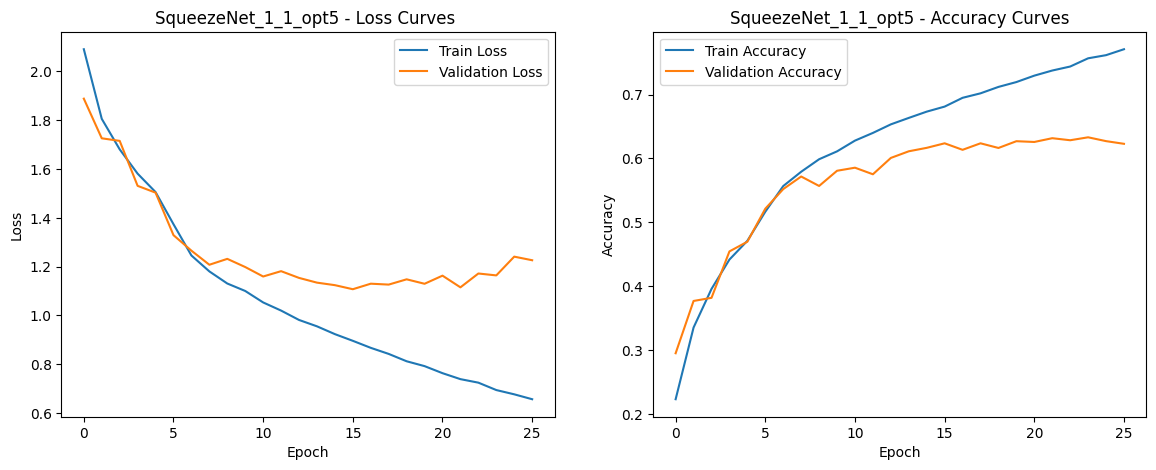

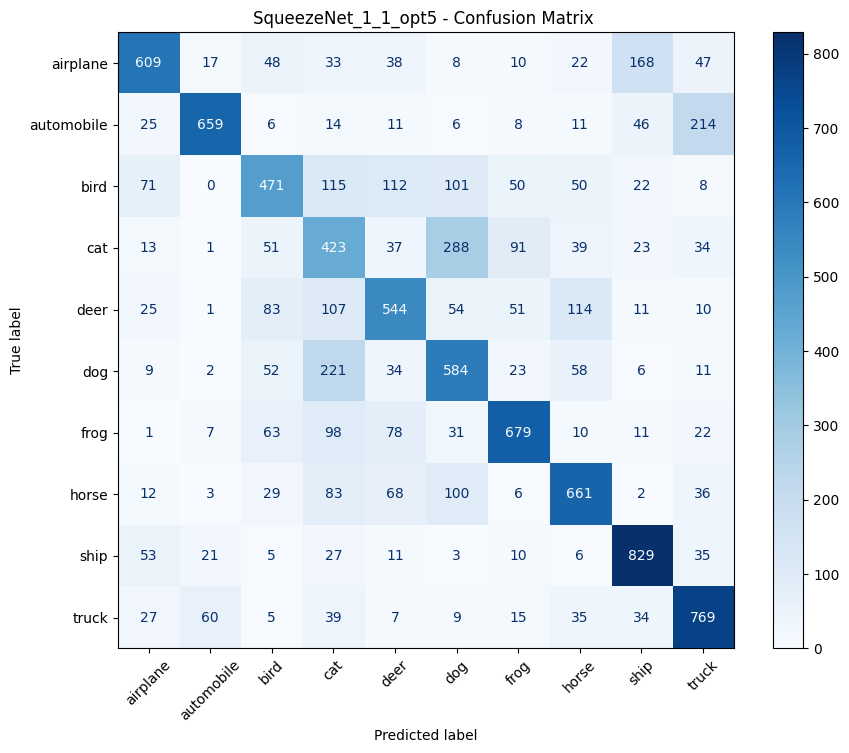

In [34]:
# Loss and accuracy curves 
model_name = "SqueezeNet_1_1_opt5"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 


### SqueezeNet 1.1 model optimisation-6

In [57]:
# SqueezeNet 1.1 with residul connections

class Fire_res(nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand1x1_channels, expand3x3_channels):
        super(Fire_res, self).__init__()
        self.in_channels = in_channels
        self.out_channels = expand1x1_channels + expand3x3_channels

        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        
        self.expand1x1 = nn.Conv2d(squeeze_channels, expand1x1_channels, kernel_size=1)
        self.expand3x3 = nn.Conv2d(squeeze_channels, expand3x3_channels, kernel_size=3, padding=1)
        
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3_activation = nn.ReLU(inplace=True)

        # If input and output channels don't match, add a 1x1 convolution to match dimensions
        self.residual_connection = nn.Conv2d(in_channels, self.out_channels, kernel_size=1) \
            if in_channels != self.out_channels else None

    def forward(self, x):
        residual = x
        x = self.squeeze_activation(self.squeeze(x))
        x = torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)

        # Add the residual if applicable
        if self.residual_connection is not None:
            residual = self.residual_connection(residual)
        
        return x + residual  # Adding the residual connection

class SqueezeNet_1_1_res(nn.Module):
    def __init__(self, num_classes=10):
        super(SqueezeNet_1_1_res, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            
            Fire_res(64, 16, 64, 64),
            Fire_res(128, 16, 64, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            
            Fire_res(128, 32, 128, 128),
            Fire_res(256, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            
            Fire_res(256, 48, 192, 192),
            Fire_res(384, 48, 192, 192),
            Fire_res(384, 64, 256, 256),
            Fire_res(512, 64, 256, 256),
        )
        
        self.final_conv = nn.Conv2d(512, num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            self.final_conv,
            nn.Identity(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


In [44]:
# DataLoaders, edit batch size
train_loader_aug = DataLoader(train_subset_aug, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader_128 = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4)

# Hyperparameter tuning
model = SqueezeNet_1_1_res(num_classes=10)
train_dataset = train_loader_aug
val_dataset = val_loader_128
optimizer=optim.Adam
learning_rate=0.001
epochs =100
patience=10
regularization=None
regularization_strength=None
models = {}
model_name = "SqueezeNet_1_1_opt6"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

Epoch 1/100, Train Loss: 3.9654, Train Accuracy: 0.2071, Validation Loss: 1.7900, Validation Accuracy: 0.3450


Epoch 2/100, Train Loss: 2.0710, Train Accuracy: 0.2701, Validation Loss: 1.7443, Validation Accuracy: 0.3715


Epoch 3/100, Train Loss: 1.9465, Train Accuracy: 0.2966, Validation Loss: 1.6760, Validation Accuracy: 0.3909


Epoch 4/100, Train Loss: 1.8699, Train Accuracy: 0.3234, Validation Loss: 1.5844, Validation Accuracy: 0.4285


Epoch 5/100, Train Loss: 1.8069, Train Accuracy: 0.3438, Validation Loss: 1.5229, Validation Accuracy: 0.4452


Epoch 6/100, Train Loss: 1.7591, Train Accuracy: 0.3623, Validation Loss: 1.5328, Validation Accuracy: 0.4437


Epoch 7/100, Train Loss: 1.7242, Train Accuracy: 0.3755, Validation Loss: 1.4640, Validation Accuracy: 0.4684


Epoch 8/100, Train Loss: 1.7053, Train Accuracy: 0.3875, Validation Loss: 1.4486, Validation Accuracy: 0.4734


Epoch 9/100, Train Loss: 1.6661, Train Accuracy: 0.4003, Validation Loss: 1.4023, Validation Accuracy: 0.4923


Epoch 10/100, Train Loss: 1.6409, Train Accuracy: 0.4122, Validation Loss: 1.3355, Validation Accuracy: 0.5252


Epoch 11/100, Train Loss: 1.6111, Train Accuracy: 0.4251, Validation Loss: 1.3781, Validation Accuracy: 0.5035


Epoch 12/100, Train Loss: 1.5902, Train Accuracy: 0.4289, Validation Loss: 1.3493, Validation Accuracy: 0.5137


Epoch 13/100, Train Loss: 1.5782, Train Accuracy: 0.4346, Validation Loss: 1.2906, Validation Accuracy: 0.5348


Epoch 14/100, Train Loss: 1.5501, Train Accuracy: 0.4486, Validation Loss: 1.3211, Validation Accuracy: 0.5261


Epoch 15/100, Train Loss: 1.5368, Train Accuracy: 0.4543, Validation Loss: 1.2398, Validation Accuracy: 0.5538


Epoch 16/100, Train Loss: 1.5178, Train Accuracy: 0.4580, Validation Loss: 1.2578, Validation Accuracy: 0.5554


Epoch 17/100, Train Loss: 1.5128, Train Accuracy: 0.4603, Validation Loss: 1.2161, Validation Accuracy: 0.5639


Epoch 18/100, Train Loss: 1.5004, Train Accuracy: 0.4662, Validation Loss: 1.2611, Validation Accuracy: 0.5480


Epoch 19/100, Train Loss: 1.4914, Train Accuracy: 0.4676, Validation Loss: 1.1862, Validation Accuracy: 0.5784


Epoch 20/100, Train Loss: 1.4816, Train Accuracy: 0.4708, Validation Loss: 1.1775, Validation Accuracy: 0.5856


Epoch 21/100, Train Loss: 1.4706, Train Accuracy: 0.4767, Validation Loss: 1.1793, Validation Accuracy: 0.5780


Epoch 22/100, Train Loss: 1.4548, Train Accuracy: 0.4813, Validation Loss: 1.2376, Validation Accuracy: 0.5689


Epoch 23/100, Train Loss: 1.4476, Train Accuracy: 0.4845, Validation Loss: 1.1150, Validation Accuracy: 0.6044


Epoch 24/100, Train Loss: 1.4457, Train Accuracy: 0.4883, Validation Loss: 1.1718, Validation Accuracy: 0.5942


Epoch 25/100, Train Loss: 1.4421, Train Accuracy: 0.4870, Validation Loss: 1.1397, Validation Accuracy: 0.6026


Epoch 26/100, Train Loss: 1.4247, Train Accuracy: 0.4949, Validation Loss: 1.1440, Validation Accuracy: 0.6013


Epoch 27/100, Train Loss: 1.4250, Train Accuracy: 0.4967, Validation Loss: 1.1128, Validation Accuracy: 0.6072


Epoch 28/100, Train Loss: 1.4082, Train Accuracy: 0.4990, Validation Loss: 1.1338, Validation Accuracy: 0.6077


Epoch 29/100, Train Loss: 1.4022, Train Accuracy: 0.5045, Validation Loss: 1.1502, Validation Accuracy: 0.6046


Epoch 30/100, Train Loss: 1.3953, Train Accuracy: 0.5083, Validation Loss: 1.0859, Validation Accuracy: 0.6227


Epoch 31/100, Train Loss: 1.3972, Train Accuracy: 0.5058, Validation Loss: 1.0844, Validation Accuracy: 0.6154


Epoch 32/100, Train Loss: 1.3868, Train Accuracy: 0.5071, Validation Loss: 1.1119, Validation Accuracy: 0.6141


Epoch 33/100, Train Loss: 1.3775, Train Accuracy: 0.5098, Validation Loss: 1.0382, Validation Accuracy: 0.6395


Epoch 34/100, Train Loss: 1.3754, Train Accuracy: 0.5139, Validation Loss: 1.0660, Validation Accuracy: 0.6216


Epoch 35/100, Train Loss: 1.3700, Train Accuracy: 0.5141, Validation Loss: 1.0973, Validation Accuracy: 0.6167


Epoch 36/100, Train Loss: 1.3632, Train Accuracy: 0.5177, Validation Loss: 0.9936, Validation Accuracy: 0.6543


Epoch 37/100, Train Loss: 1.3557, Train Accuracy: 0.5203, Validation Loss: 1.0267, Validation Accuracy: 0.6446


Epoch 38/100, Train Loss: 1.3473, Train Accuracy: 0.5232, Validation Loss: 1.0758, Validation Accuracy: 0.6315


Epoch 39/100, Train Loss: 1.3488, Train Accuracy: 0.5239, Validation Loss: 0.9821, Validation Accuracy: 0.6553


Epoch 40/100, Train Loss: 1.3309, Train Accuracy: 0.5293, Validation Loss: 0.9841, Validation Accuracy: 0.6545


Epoch 41/100, Train Loss: 1.3416, Train Accuracy: 0.5297, Validation Loss: 1.0495, Validation Accuracy: 0.6353


Epoch 42/100, Train Loss: 1.3281, Train Accuracy: 0.5323, Validation Loss: 0.9961, Validation Accuracy: 0.6550


Epoch 43/100, Train Loss: 1.3160, Train Accuracy: 0.5365, Validation Loss: 0.9736, Validation Accuracy: 0.6643


Epoch 44/100, Train Loss: 1.3146, Train Accuracy: 0.5351, Validation Loss: 0.9714, Validation Accuracy: 0.6650


Epoch 45/100, Train Loss: 1.3044, Train Accuracy: 0.5393, Validation Loss: 0.9680, Validation Accuracy: 0.6677


Epoch 46/100, Train Loss: 1.3091, Train Accuracy: 0.5372, Validation Loss: 0.9909, Validation Accuracy: 0.6577


Epoch 47/100, Train Loss: 1.3092, Train Accuracy: 0.5375, Validation Loss: 1.0248, Validation Accuracy: 0.6428


Epoch 48/100, Train Loss: 1.2899, Train Accuracy: 0.5452, Validation Loss: 0.9893, Validation Accuracy: 0.6617


Epoch 49/100, Train Loss: 1.2909, Train Accuracy: 0.5478, Validation Loss: 0.9238, Validation Accuracy: 0.6786


Epoch 50/100, Train Loss: 1.2971, Train Accuracy: 0.5447, Validation Loss: 0.9671, Validation Accuracy: 0.6733


Epoch 51/100, Train Loss: 1.2868, Train Accuracy: 0.5485, Validation Loss: 0.9851, Validation Accuracy: 0.6592


Epoch 52/100, Train Loss: 1.2840, Train Accuracy: 0.5482, Validation Loss: 0.9750, Validation Accuracy: 0.6612


Epoch 53/100, Train Loss: 1.2675, Train Accuracy: 0.5530, Validation Loss: 0.9825, Validation Accuracy: 0.6612


Epoch 54/100, Train Loss: 1.2820, Train Accuracy: 0.5497, Validation Loss: 0.9624, Validation Accuracy: 0.6636


Epoch 55/100, Train Loss: 1.2634, Train Accuracy: 0.5536, Validation Loss: 0.9531, Validation Accuracy: 0.6671


Epoch 56/100, Train Loss: 1.2624, Train Accuracy: 0.5566, Validation Loss: 0.9321, Validation Accuracy: 0.6796


Epoch 57/100, Train Loss: 1.2610, Train Accuracy: 0.5595, Validation Loss: 0.9379, Validation Accuracy: 0.6776


Epoch 58/100, Train Loss: 1.2649, Train Accuracy: 0.5545, Validation Loss: 0.9311, Validation Accuracy: 0.6791


Epoch 59/100, Train Loss: 1.2594, Train Accuracy: 0.5534, Validation Loss: 0.9791, Validation Accuracy: 0.6660
Early stopping...
Training complete. Final model saved at 'models/SqueezeNet_1_1_opt6.pth'


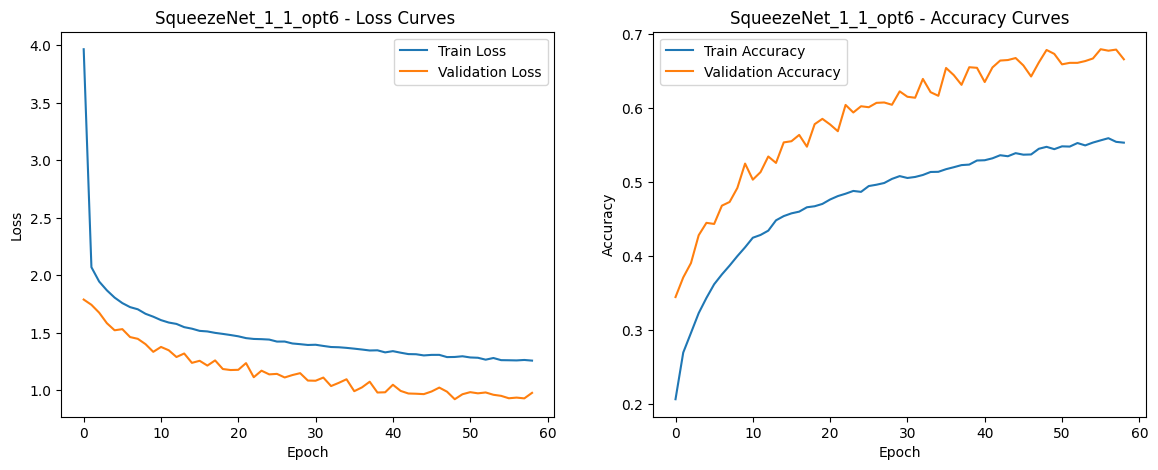

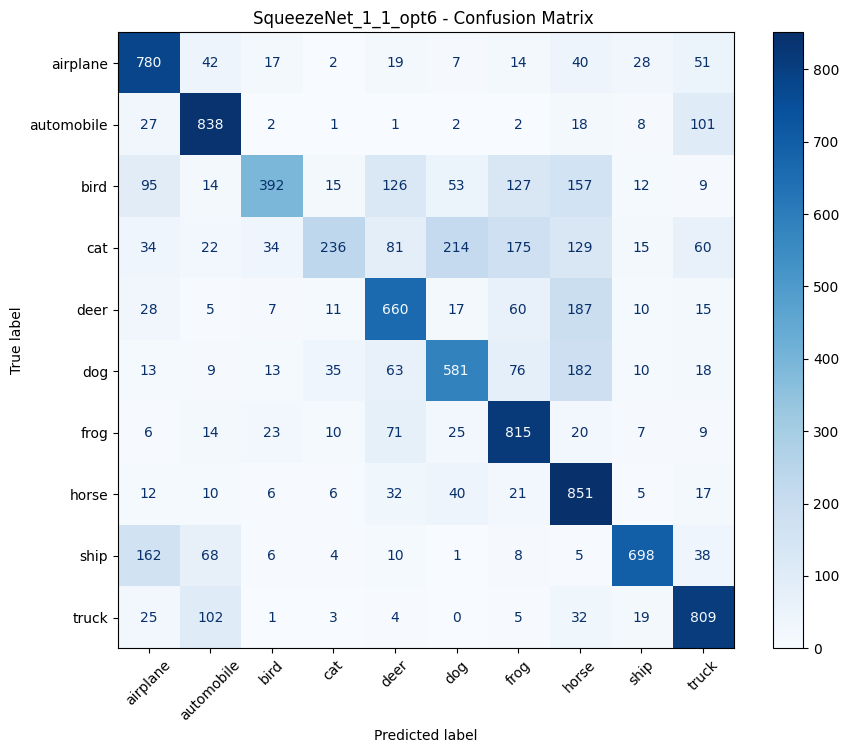

In [45]:
# Loss and accuracy curves 
model_name = "SqueezeNet_1_1_opt6"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 


### SqueezeNet 1.1 model optimisation-7

In [ ]:
# DataLoaders, edit batch size
train_loader_aug = DataLoader(train_subset_aug, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader_128 = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4)

# Hyperparameter tuning
model = SqueezeNet_1_1(num_classes=10)
train_dataset = train_loader_aug
val_dataset = val_loader_128
optimizer=optim.NAdam
learning_rate=0.001
epochs =100
patience=10
regularization=None
regularization_strength=None
models = {}
model_name = "SqueezeNet_1_1_opt7"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

In [ ]:
# Loss and accuracy curves 
model_name = "SqueezeNet_1_1_opt7"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 


### Comparing models

SqueezeNet_base Accuracy: 0.6043%
SqueezeNet_opt1 Accuracy: 0.5413%
SqueezeNet_opt2 Accuracy: 0.5452%
SqueezeNet_opt3 Accuracy: 0.5478%
SqueezeNet_opt4 Accuracy: 0.5612%
SqueezeNet_opt5 Accuracy: 0.6228%
SqueezeNet_opt6 Accuracy: 0.6796%


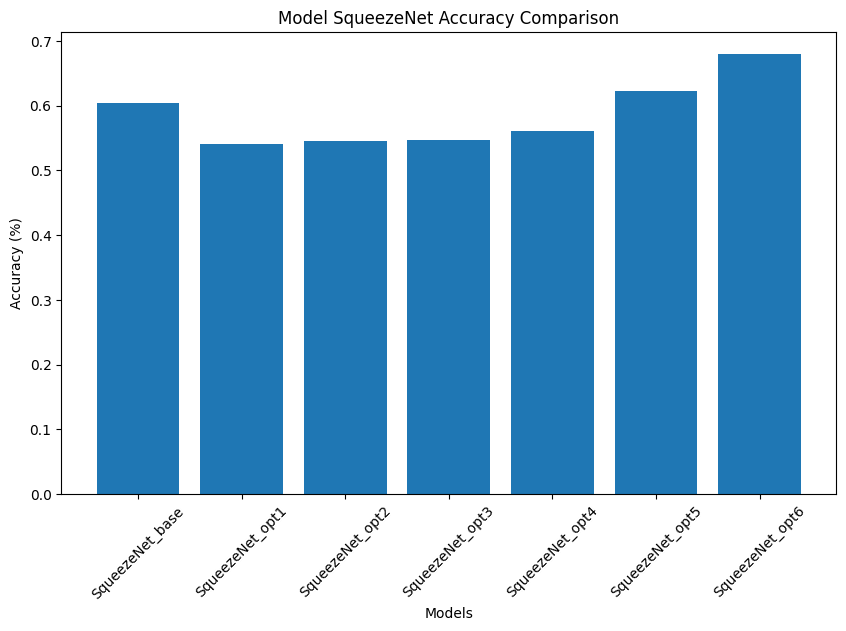

In [50]:
#Define the accuracy values

SqueezeNet_base_acc = 0.6043
SqueezeNet_opt1_acc = 0.5413
SqueezeNet_opt2_acc = 0.5452
SqueezeNet_opt3_acc = 0.5478
SqueezeNet_opt4_acc = 0.5612
SqueezeNet_opt5_acc = 0.6228
SqueezeNet_opt6_acc = 0.6796
#SqueezeNet_opt7_acc = np.max(val_acc_SqueezeNet_1_1_opt7)


model_accuracies = {
    "SqueezeNet_base": SqueezeNet_base_acc,
    "SqueezeNet_opt1": SqueezeNet_opt1_acc,
    "SqueezeNet_opt2": SqueezeNet_opt2_acc,
    "SqueezeNet_opt3": SqueezeNet_opt3_acc,
    "SqueezeNet_opt4": SqueezeNet_opt4_acc,
    "SqueezeNet_opt5": SqueezeNet_opt5_acc,
    "SqueezeNet_opt6": SqueezeNet_opt6_acc

}

# Print each model's accuracy
for model_name, accuracy in model_accuracies.items():
    print(f"{model_name} Accuracy: {accuracy:.4f}%")

# Plotting the accuracies using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.title("Model SqueezeNet Accuracy Comparison")
plt.show()


### Evaluate to test dataset

D:\Users\a1913327\AppData\Local\Temp\2\ipykernel_1332\4023466330.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/SqueezeNet_1_1

Test Loss: 0.9943
Test Accuracy: 66.48%


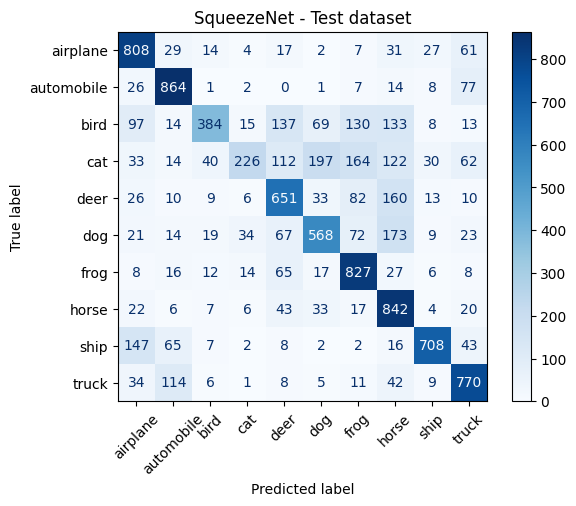

In [58]:
# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Re-instantiate your model architecture
# Replace `YourModelClass` with the actual class name of your model
model = SqueezeNet_1_1_res()
model.to(device)

# Load the model state_dict
model.load_state_dict(torch.load('models/SqueezeNet_1_1_opt6.pth'))
model.eval()

# Define the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

# Initialize variables to store metrics
test_loss = 0
correct = 0
total = 0
all_labels = []
all_predictions = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the GPU
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = F.cross_entropy(outputs, labels)
        test_loss += loss.item() * labels.size(0)  # Accumulate loss
        
        # Get predicted classes
        _, predicted = torch.max(outputs, 1)
        
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store predictions and labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate average loss and accuracy
average_loss = test_loss / total
accuracy = 100 * correct / total

print(f'Test Loss: {average_loss:.4f}')
print(f'Test Accuracy: {accuracy:.2f}%')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='Blues')
plt.plot(figsize=(8,8))
plt.xticks(rotation=45)
plt.title('SqueezeNet - Test dataset')
plt.show()

